In [267]:
import numpy as np
import pandas as pd

import datetime 
import statsmodels as sm

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [268]:
sp_500 = pd.read_csv('/content/SP500.csv')
sp_500

,DATE,SP500
0,2014-01-02,1831.98
1,2014-01-03,1831.37
2,2014-01-06,1826.77
3,2014-01-07,1837.88
4,2014-01-08,1837.49
...,...,...
2277,2022-09-26,3655.04
2278,2022-09-27,3647.29
2279,2022-09-28,3719.04
2280,2022-09-29,3640.47


In [269]:
sp_500.head(10)

,DATE,SP500
0,2014-01-02,1831.98
1,2014-01-03,1831.37
2,2014-01-06,1826.77
3,2014-01-07,1837.88
4,2014-01-08,1837.49
5,2014-01-09,1838.13
6,2014-01-10,1842.37
7,2014-01-13,1819.20
8,2014-01-14,1838.88
9,2014-01-15,1848.38


In [270]:
sp_500[sp_500['SP500'] == '.'].shape

(79, 2)

In [271]:
sp_500.dtypes

DATE     object
SP500    object
dtype: object

In [272]:
sp_500['SP500'] = pd.to_numeric(sp_500['SP500'], errors='coerce')
sp_500['DATE'] = pd.to_datetime(sp_500['DATE']).dt.date

In [273]:
sp_500.dropna(inplace=True)

In [274]:
sp_500.set_index('DATE', inplace=True)

In [275]:
sp_500.dtypes

SP500    float64
dtype: object

In [276]:
sp_500.head()

,SP500
DATE,
2014-01-02,1831.98
2014-01-03,1831.37
2014-01-06,1826.77
2014-01-07,1837.88
2014-01-08,1837.49


In [277]:
df_sample = sp_500[(sp_500.index < datetime.date(2020,1,1))] 

### EXPLORATORY DATA ANALYSIS (EDA)

In [278]:
roll_avg_10 = df_sample.SP500.rolling(window=10).mean()
roll_avg_30 = df_sample.SP500.rolling(window=30).mean()
roll_avg_70 = df_sample.SP500.rolling(window=70).mean()

[Text(0, 0.5, 'S&P 500'), Text(0.5, 0, 'Date')]

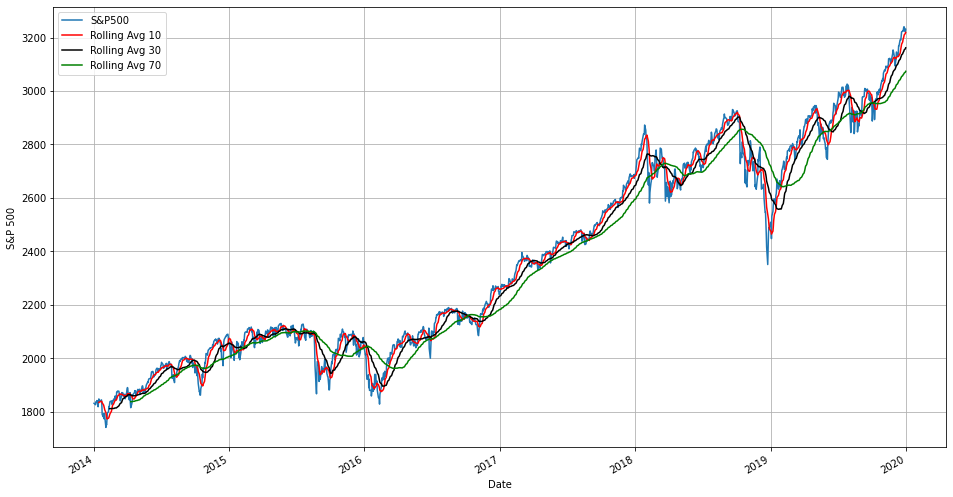

In [279]:
fig, ax = plt.subplots(figsize=(16, 9))
fig.autofmt_xdate()
ax.plot(df_sample.SP500, label='S&P500', color='tab:blue')
ax.plot(roll_avg_10, label='Rolling Avg 10', color='r')
ax.plot(roll_avg_30, label='Rolling Avg 30', color='k')
ax.plot(roll_avg_70, label='Rolling Avg 70', color='g')
ax.legend()
ax.grid()
ax.set(xlabel='Date',ylabel='S&P 500')

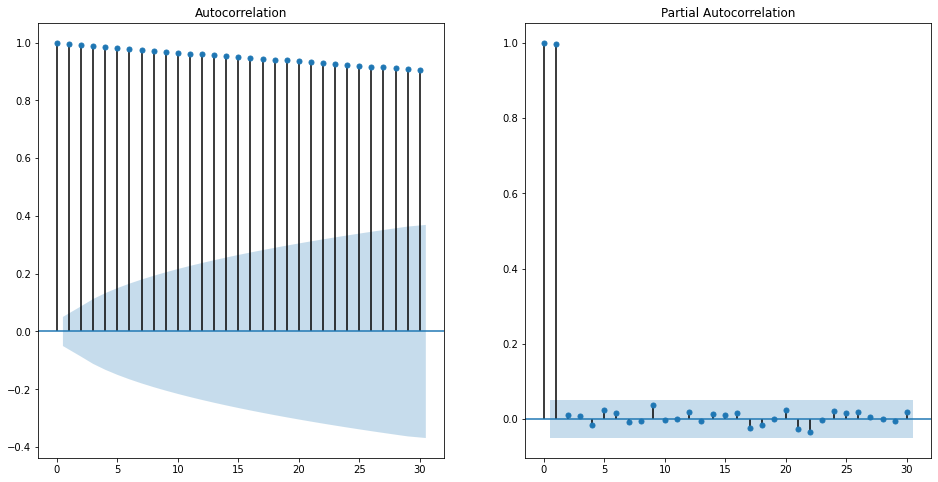

In [280]:
import statsmodels.api as sm

# Graph data
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fig = sm.graphics.tsa.plot_acf(df_sample.iloc[1:]['SP500'], lags=30, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df_sample.iloc[1:]['SP500'], lags=30, ax=axes[1])

In [281]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))

In [282]:
check_stationarity(df_sample.SP500)

The test statistic: 0.051249
p-value: 0.962571
Critical Values:
1%: -3.435
5%: -2.863
10%: -2.568


In [283]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [284]:
df_diff =  difference(df_sample.SP500, 1)

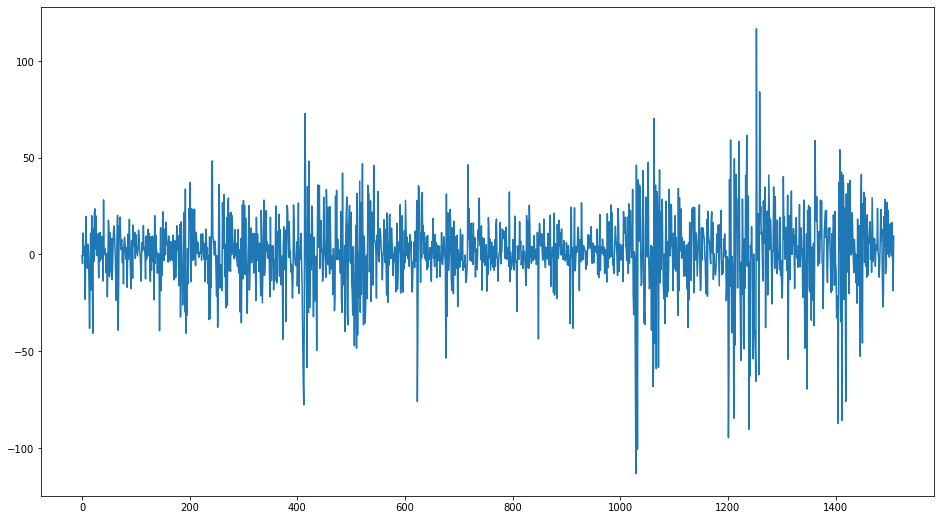

In [285]:
df_diff.plot(figsize=(16, 9))

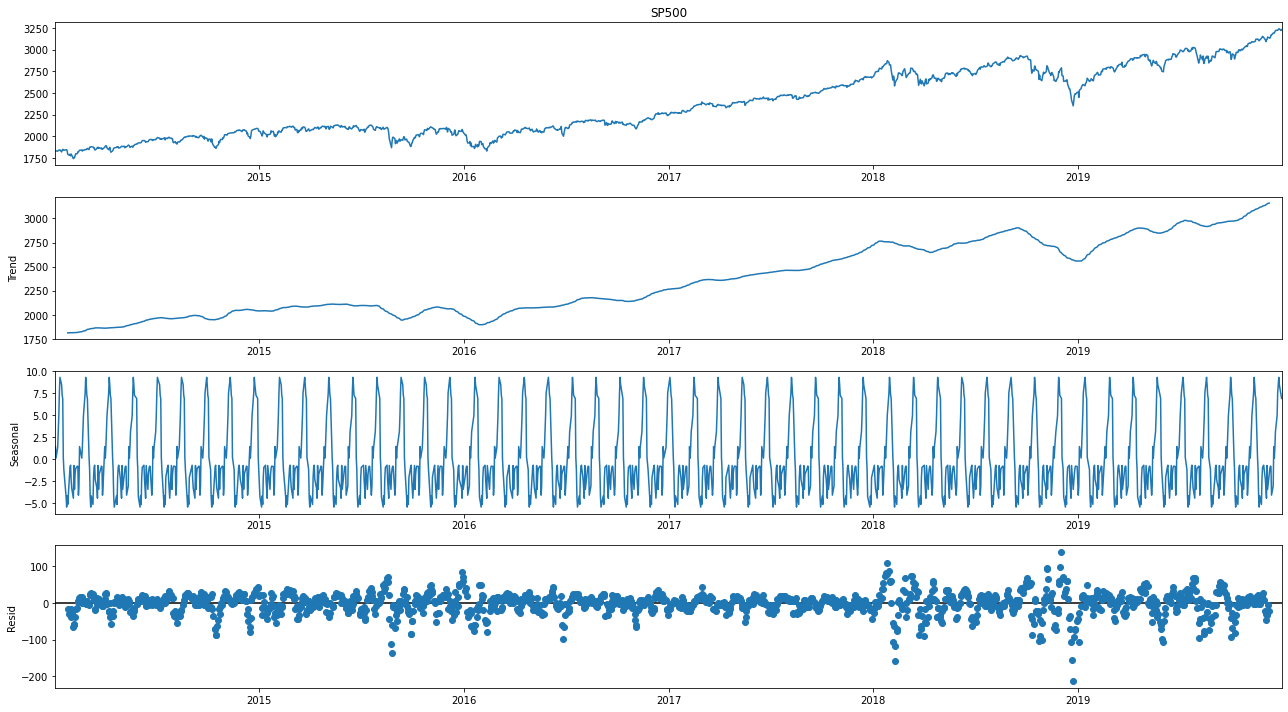

In [286]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_sample['SP500'], model='additive', freq=30)
plt.rcParams["figure.figsize"] = [18, 10]
fig = decomposition.plot()

In [287]:
df_sample = df_sample.assign(y_log=np.log(df_sample.SP500))
df_sample.head()

,SP500,y_log
DATE,,
2014-01-02,1831.98,7.513153
2014-01-03,1831.37,7.512820
2014-01-06,1826.77,7.510305
2014-01-07,1837.88,7.516368
2014-01-08,1837.49,7.516156


## ARIMA

In [288]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_sample.y_log, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.y_log   No. Observations:                 1509
Model:                 ARIMA(1, 1, 2)   Log Likelihood                5098.124
Method:                       css-mle   S.D. of innovations              0.008
Date:                Sun, 06 Nov 2022   AIC                         -10186.248
Time:                        08:35:41   BIC                         -10159.652
Sample:                             1   HQIC                        -10176.343
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.844      0.065   -2.36e-05       0.001
ar.L1.D.y_log    -0.7496      0.157     -4.776      0.000      -1.057      -0.442
ma.L1.D.y_log     0.7319      0.158     

In [289]:
model = ARIMA(df_sample.y_log, order=(3,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.y_log   No. Observations:                 1508
Model:                 ARIMA(3, 2, 1)   Log Likelihood                5087.648
Method:                       css-mle   S.D. of innovations              0.008
Date:                Sun, 06 Nov 2022   AIC                         -10163.297
Time:                        08:35:42   BIC                         -10131.385
Sample:                             2   HQIC                        -10151.412
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.124e-07   4.87e-07      0.436      0.663   -7.42e-07    1.17e-06
ar.L1.D2.y_log    -0.0650      0.026     -2.516      0.012      -0.116      -0.014
ar.L2.D2.y_log    -0.0379      0.026

In [290]:
import itertools

p = [0, 1, 2, 4, 6, 8, 10]
d = range(0, 3)
q = range(0, 3)

pdq = list(itertools.product(p, d, q))

In [291]:
for param in pdq:
  try:
    model = ARIMA(df_sample.y_log, order=param)
    results = model.fit()
    print('ARIMA{} - AIC:{}'.format(param, results.aic))
  except:
    continue

ARIMA(0, 0, 0) - AIC:-1264.074941538794
ARIMA(0, 0, 1) - AIC:-3256.3603483635616
ARIMA(0, 0, 2) - AIC:-4814.161742167567
ARIMA(0, 1, 0) - AIC:-10186.41242029488
ARIMA(0, 1, 1) - AIC:-10185.025524786193
ARIMA(0, 1, 2) - AIC:-10185.385031778853
ARIMA(0, 2, 0) - AIC:-9104.49710920587
ARIMA(0, 2, 1) - AIC:-10169.533852995717
ARIMA(0, 2, 2) - AIC:-10168.111739011545
ARIMA(1, 0, 0) - AIC:-10181.608973572454
ARIMA(1, 0, 1) - AIC:-10180.068012339903
ARIMA(1, 0, 2) - AIC:-10180.09803762842
ARIMA(1, 1, 0) - AIC:-10184.97902607405
ARIMA(1, 1, 1) - AIC:-10191.953940607675
ARIMA(1, 1, 2) - AIC:-10186.247903882777
ARIMA(1, 2, 0) - AIC:-9517.828951830827
ARIMA(1, 2, 1) - AIC:-10135.420519264788
ARIMA(1, 2, 2) - AIC:-10167.88659982349
ARIMA(2, 0, 0) - AIC:-10180.03558962033
ARIMA(2, 0, 1) - AIC:-10139.982894458888
ARIMA(2, 0, 2) - AIC:-10181.119817345874
ARIMA(2, 1, 0) - AIC:-10185.221361422251
ARIMA(2, 1, 1) - AIC:-10186.223324119874
ARIMA(2, 1, 2) - AIC:-10190.902451475262
ARIMA(2, 2, 0) - AIC:-9734

In [292]:
best_order = (10, 1, 2)
model = ARIMA(df_sample.y_log, order=best_order)
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.y_log   No. Observations:                 1509
Model:                ARIMA(10, 1, 2)   Log Likelihood                5109.684
Method:                       css-mle   S.D. of innovations              0.008
Date:                Sun, 06 Nov 2022   AIC                         -10191.369
Time:                        08:43:41   BIC                         -10116.900
Sample:                             1   HQIC                        -10163.635
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0004      0.000      2.064      0.039    1.88e-05       0.001
ar.L1.D.y_log      0.4298      0.026     16.692      0.000       0.379       0.480
ar.L2.D.y_log     -1.0183      0.028

[]

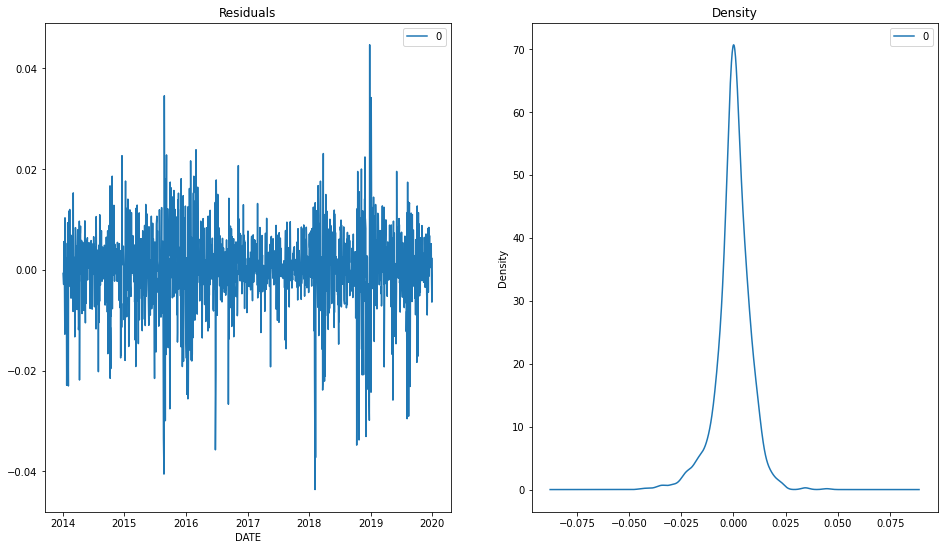

In [293]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(16, 9))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.plot()

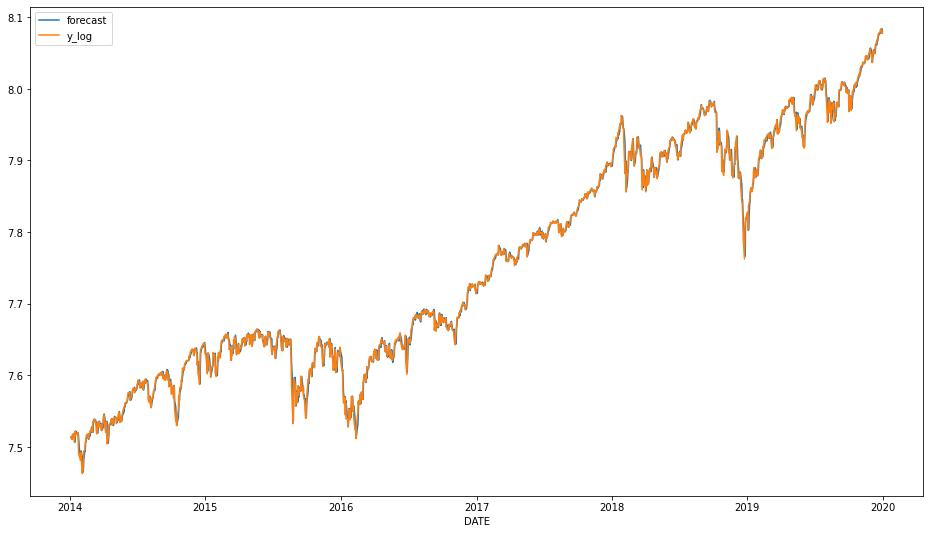

In [294]:
from statsmodels.graphics.gofplots import qqplot_2samples
n, m = 16, 9
with plt.rc_context():
  plt.rc("figure", figsize=(n,m))
  model_fit.plot_predict(dynamic=False)

In [295]:
df_sample

,SP500,y_log
DATE,,
2014-01-02,1831.98,7.513153
2014-01-03,1831.37,7.512820
2014-01-06,1826.77,7.510305
2014-01-07,1837.88,7.516368
2014-01-08,1837.49,7.516156
...,...,...
2019-12-24,3223.38,8.078186
2019-12-26,3239.91,8.083301
2019-12-27,3240.02,8.083335


In [384]:
TRAIN_END_INDEX = 1350
# Create Training and Test
train = df_sample.y_log[:TRAIN_END_INDEX]
test = df_sample.y_log[TRAIN_END_INDEX:]

In [385]:
# Build Model
model = ARIMA(train, order=best_order)  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(160, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

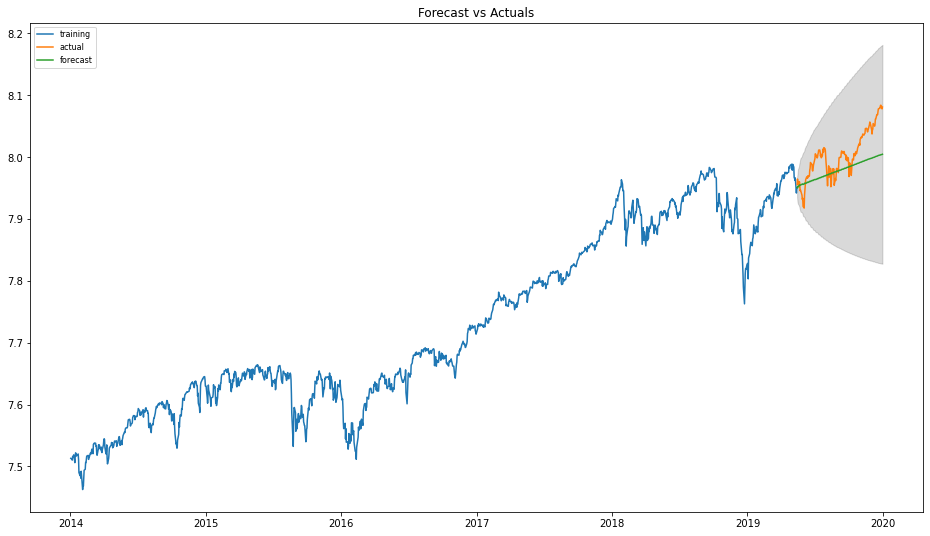

In [386]:
# Plot
plt.figure(figsize=(16, 9))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

In [387]:
fc_series.index

Index([2019-05-15, 2019-05-16, 2019-05-17, 2019-05-20, 2019-05-21, 2019-05-22,
       2019-05-23, 2019-05-24, 2019-05-28, 2019-05-29,
       ...
       2019-12-17, 2019-12-18, 2019-12-19, 2019-12-20, 2019-12-23, 2019-12-24,
       2019-12-26, 2019-12-27, 2019-12-30, 2019-12-31],
      dtype='object', name='DATE', length=160)

In [388]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [389]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('ARIMA model mse :', mean_squared_error(np.exp(test), np.exp(fc_series)))
print('ARIMA model mae :', mean_absolute_error(np.exp(test), np.exp(fc_series)))
print('ARIMA model mape :', mean_absolute_percentage_error(np.exp(test), np.exp(fc_series)))

ARIMA model mse : 11043.535389775516
ARIMA model mae : 85.41271498041634
ARIMA model mape : 0.027977468870840037


##PROPHET

In [ ]:
pip install pystan~=2.14


In [ ]:
pip install fbprophet

In [391]:
from fbprophet import Prophet

In [392]:
df_sample

,SP500,y_log
DATE,,
2014-01-02,1831.98,7.513153
2014-01-03,1831.37,7.512820
2014-01-06,1826.77,7.510305
2014-01-07,1837.88,7.516368
2014-01-08,1837.49,7.516156
...,...,...
2019-12-24,3223.38,8.078186
2019-12-26,3239.91,8.083301
2019-12-27,3240.02,8.083335


In [393]:
df_prophet = df_sample.copy()

In [394]:
df_prophet['DATE'] = df_sample.index
df_prophet.head()

,SP500,y_log,DATE
DATE,,,
2014-01-02,1831.98,7.513153,2014-01-02
2014-01-03,1831.37,7.512820,2014-01-03
2014-01-06,1826.77,7.510305,2014-01-06
2014-01-07,1837.88,7.516368,2014-01-07
2014-01-08,1837.49,7.516156,2014-01-08


In [395]:
df_prophet = df_prophet.rename(columns={'SP500':'y', 'DATE':'ds'})
df_prophet

,y,y_log,ds
DATE,,,
2014-01-02,1831.98,7.513153,2014-01-02
2014-01-03,1831.37,7.512820,2014-01-03
2014-01-06,1826.77,7.510305,2014-01-06
2014-01-07,1837.88,7.516368,2014-01-07
2014-01-08,1837.49,7.516156,2014-01-08
...,...,...,...
2019-12-24,3223.38,8.078186,2019-12-24
2019-12-26,3239.91,8.083301,2019-12-26
2019-12-27,3240.02,8.083335,2019-12-27


In [449]:
TRAIN_END_INDEX = 1400

# Create Training and Test df
train = df_prophet[:TRAIN_END_INDEX]
test = df_prophet[TRAIN_END_INDEX:]

In [450]:
model = Prophet(daily_seasonality=True) #instantiate Prophet
model.fit(train); #fit the model with your dataframe

In [451]:
future_data = model.make_future_dataframe(periods=20)

In [452]:
forecast_data = model.predict(future_data)

In [453]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1415,2019-08-10,2921.025918,2851.809517,2985.247833
1416,2019-08-11,2919.746827,2848.422402,2991.462258
1417,2019-08-12,2924.567730,2854.500998,2991.284680
1418,2019-08-13,2927.098693,2853.490034,2993.878942
1419,2019-08-14,2926.003833,2858.231345,2996.903271


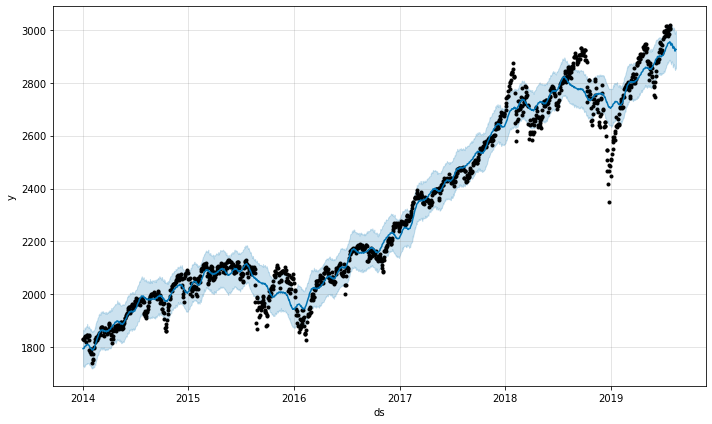

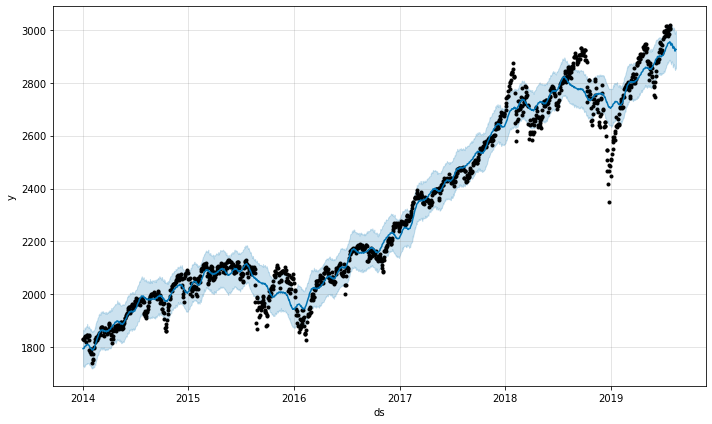

In [454]:
model.plot(forecast_data)

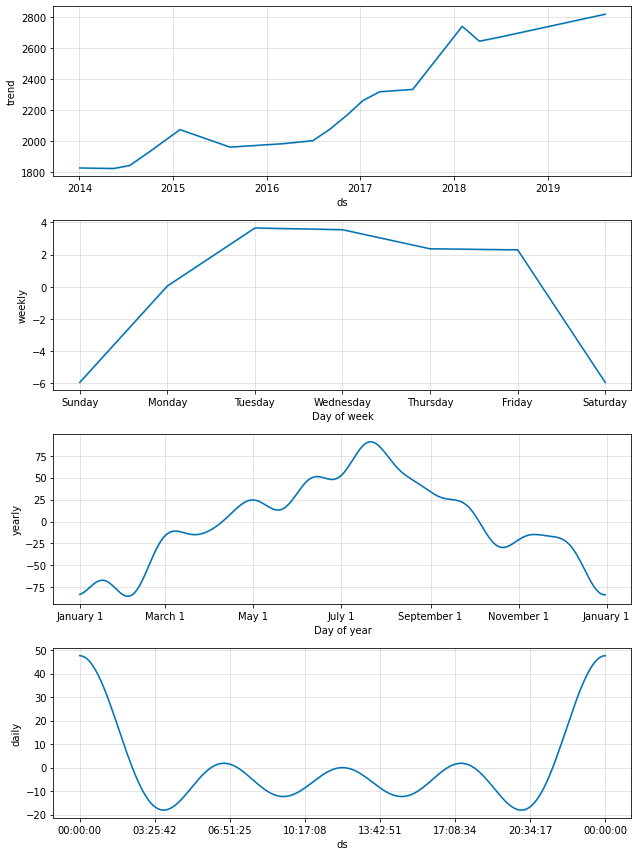

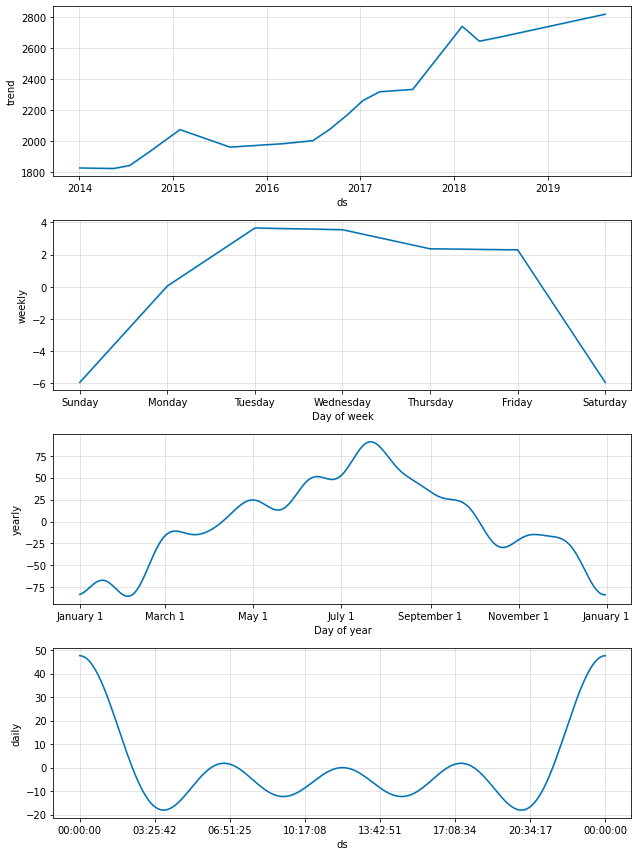

In [455]:
model.plot_components(forecast_data)

In [456]:
forecast = forecast_data.yhat[-110:]

In [457]:
test['y'][:5]

DATE
2019-07-26    3025.86
2019-07-29    3020.97
2019-07-30    3013.18
2019-07-31    2980.38
2019-08-01    2953.56
Name: y, dtype: float64

In [458]:
from sklearn.metrics import mean_squared_error

print('Prophet model MAE :', mean_squared_error(test['y'], forecast))
print('Prophet model MSE :', mean_absolute_error(test['y'], forecast))
print('Prophet model MAPE :', mean_absolute_percentage_error(test['y'], forecast))

Prophet model MAE : 25127.87657490663
Prophet model MSE : 141.9535480087701
Prophet model MAPE : 0.0462442087911709


## LSTM


In [497]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [498]:
scaled_df = df_sample.SP500.values.reshape(df_sample.SP500.shape[0], 1)
scaled_df = scaler.fit_transform(scaled_df)
scaled_df.shape

(1510, 1)

In [499]:
def preprocess(df, look_back):
    X, y = [], []
    for i in range(look_back, len(df)):
        X.append(df[i-look_back:i,0])
        y.append(df[i,0])
    return np.array(X),np.array(y)

In [500]:
look_back = 60
X, y = preprocess(scaled_df, look_back)

In [501]:
X_train,X_test = X[:int(X.shape[0]*0.85)],X[int(X.shape[0]*0.85):]
y_train,y_test = y[:int(y.shape[0]*0.85)],y[int(y.shape[0]*0.85):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

1232
218
1232
218


In [502]:
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [503]:
#Build the model
model1 = Sequential()
model1.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
model1.add(Dense(1))
model1.compile(optimizer='adam',loss='mse')

model1.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 64)                16896     
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [504]:
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

In [505]:
history1 = model1.fit(X_train,y_train,epochs=150, validation_data=(X_test,y_test),shuffle=False)

Epoch 1/150
39/39 [==============================] - 4s 46ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 2/150
39/39 [==============================] - 1s 31ms/step - loss: 0.0041 - val_loss: 0.0086
Epoch 3/150
39/39 [==============================] - 1s 31ms/step - loss: 0.0022 - val_loss: 0.0068
Epoch 4/150
39/39 [==============================] - 1s 30ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 5/150
39/39 [==============================] - 1s 31ms/step - loss: 0.0035 - val_loss: 0.0056
Epoch 6/150
39/39 [==============================] - 1s 31ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 7/150
39/39 [==============================] - 1s 31ms/step - loss: 0.0064 - val_loss: 0.0016
Epoch 8/150
39/39 [==============================] - 1s 31ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 9/150
39/39 [==============================] - 1s 31ms/step - loss: 0.0059 - val_loss: 0.0018
Epoch 10/150
39/39 [==============================] - 1s 31ms/step - loss: 0.0037 - val_loss: 0.0010

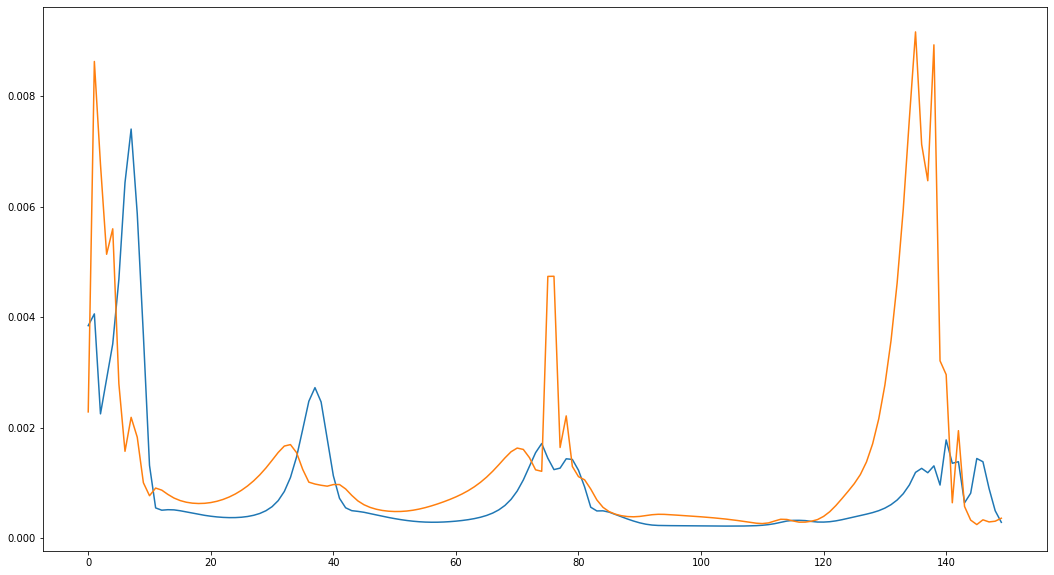

In [506]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

7/7 [==============================] - 1s 11ms/step


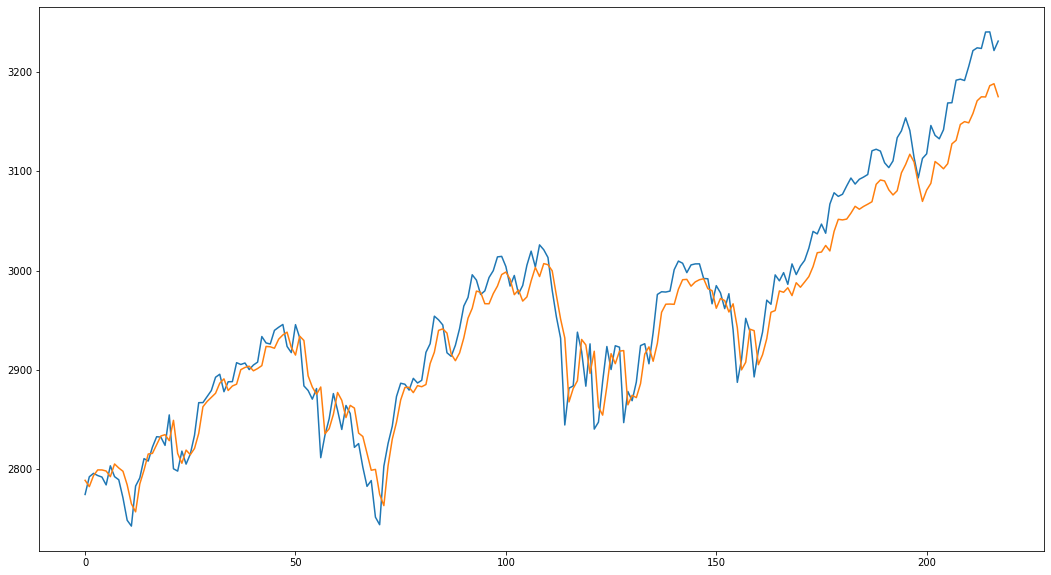

In [507]:
Xt = model1.predict(X_test)
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(Xt))

In [508]:
X_test.shape[0]

218

In [509]:
act = []
pred = []
for i in range(X_test.shape[0]):
  # i=274
  Xt = model1.predict(X_test[i].reshape(1, 60,1))
  # print('predicted:{0}, actual:{1}'.format(scaler.inverse_transform(Xt),scaler.inverse_transform(y_test[i].reshape(-1,1))))
  pred.append(scaler.inverse_transform(Xt))
  act.append(scaler.inverse_transform(y_test[i].reshape(-1,1)))

1/1 [==============================] - 0s 22ms/step


In [510]:
result_df = pd.DataFrame({'pred':list(np.reshape(pred, (-1))),'act':list(np.reshape(act, (-1)))})
result_df.head(20)

,pred,act
0,2789.103271,2774.88
1,2782.778076,2792.67
2,2793.837646,2796.11
3,2799.566895,2793.90
4,2799.546387,2792.38
5,2798.452637,2784.49
6,2792.787598,2803.69
7,2805.545654,2792.81
8,2801.498535,2789.65
9,2798.200684,2771.45


In [511]:
result_df.shape

(218, 2)

In [512]:
test = result_df['act']
forecast = result_df['pred']

In [513]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [514]:
print('LSTM model MSE :', mean_squared_error(test, forecast))
print('LSTM model MAE :', mean_absolute_error(test, forecast))
print('LSTM model MAPE :', mean_absolute_percentage_error(test, forecast))

LSTM model MSE : 803.1967823959926
LSTM model MAE : 22.720325490969042
LSTM model MAPE : 0.007623073491562121


## Stacked LSTM MODEL

In [515]:
#Build the model
model2 = Sequential()
model2.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))
model2.add(LSTM(64, return_sequences=True))
model2.add(LSTM(64))
model2.add(Dense(1))
model2.compile(optimizer='adam',loss='mse')

model2.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 60, 64)            16896     
                                                                 
 lstm_50 (LSTM)              (None, 60, 64)            33024     
                                                                 
 lstm_51 (LSTM)              (None, 64)                33024     
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________


In [516]:
history2 = model2.fit(X_train,y_train,epochs=150, validation_data=(X_test,y_test), shuffle=False)

Epoch 1/150
39/39 [==============================] - 12s 148ms/step - loss: 0.0040 - val_loss: 0.0158
Epoch 2/150
39/39 [==============================] - 4s 107ms/step - loss: 0.0055 - val_loss: 0.0322
Epoch 3/150
39/39 [==============================] - 4s 108ms/step - loss: 0.0081 - val_loss: 0.0185
Epoch 4/150
39/39 [==============================] - 4s 107ms/step - loss: 0.0126 - val_loss: 0.0100
Epoch 5/150
39/39 [==============================] - 4s 106ms/step - loss: 0.0196 - val_loss: 0.0393
Epoch 6/150
39/39 [==============================] - 4s 108ms/step - loss: 0.0152 - val_loss: 0.0162
Epoch 7/150
39/39 [==============================] - 4s 107ms/step - loss: 0.0216 - val_loss: 0.0128
Epoch 8/150
39/39 [==============================] - 4s 109ms/step - loss: 0.0234 - val_loss: 0.0053
Epoch 9/150
39/39 [==============================] - 4s 107ms/step - loss: 0.0155 - val_loss: 0.0038
Epoch 10/150
39/39 [==============================] - 4s 107ms/step - loss: 0.0123 - val_l

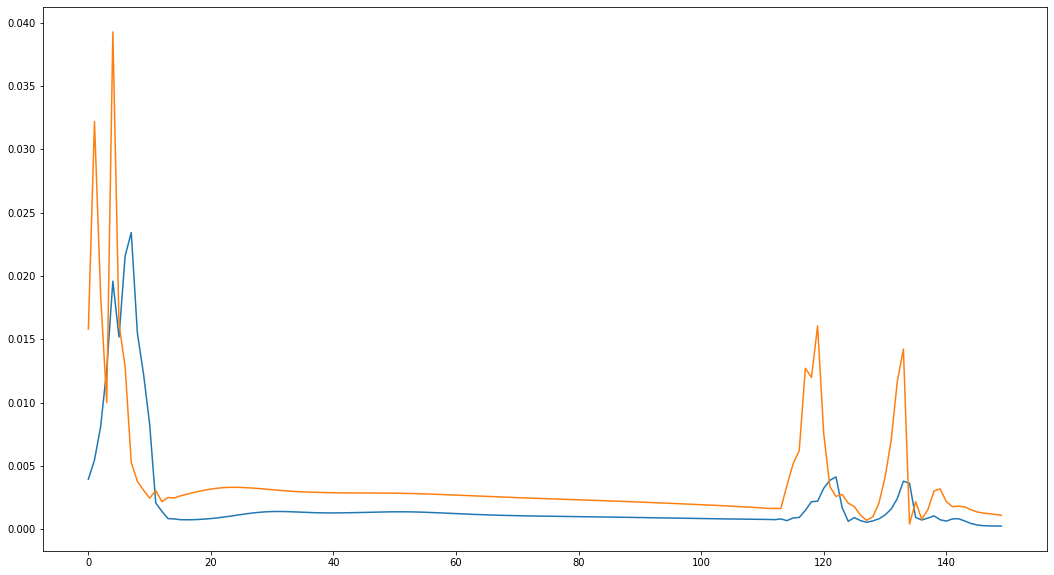

In [517]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

7/7 [==============================] - 2s 30ms/step


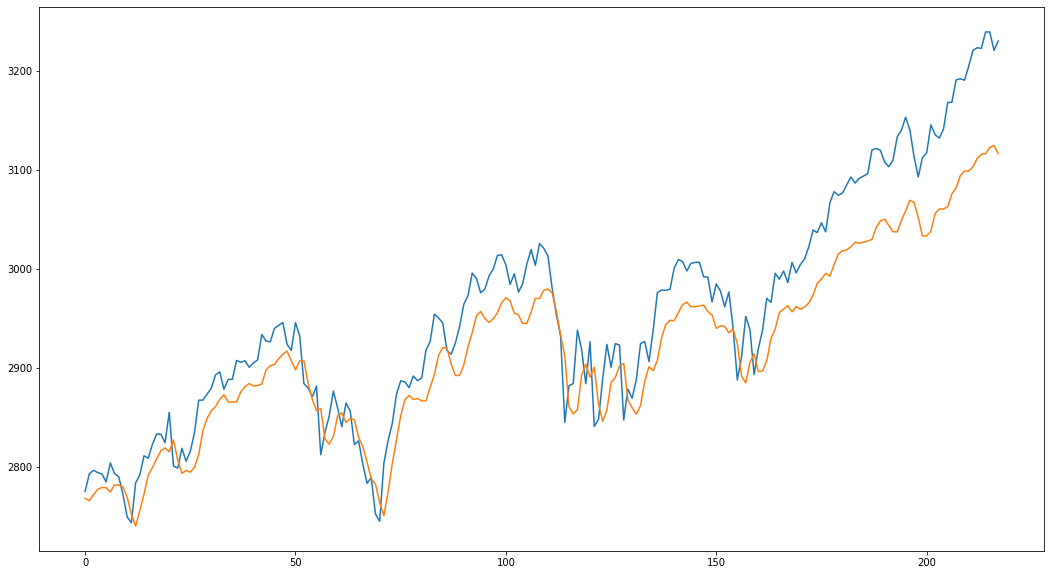

In [518]:
Xt2 = model2.predict(X_test)
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(Xt2))

In [519]:
act2 = []
pred2 = []
for i in range(X_test.shape[0]):
  # i=274
  Xt2 = model2.predict(X_test[i].reshape(1, 60,1))
  # print('predicted:{0}, actual:{1}'.format(scaler.inverse_transform(Xt),scaler.inverse_transform(y_test[i].reshape(-1,1))))
  pred2.append(scaler.inverse_transform(Xt2))
  act2.append(scaler.inverse_transform(y_test[i].reshape(-1,1)))

1/1 [==============================] - 0s 30ms/step


In [520]:
result_df2 = pd.DataFrame({'pred':list(np.reshape(pred2, (-1))),'act':list(np.reshape(act2, (-1)))})
result_df2.head()

,pred,act
0,2767.930420,2774.88
1,2765.319580,2792.67
2,2771.486328,2796.11
3,2776.871826,2793.90
4,2778.822998,2792.38


In [521]:
test2 = result_df2['act']
forecast2 = result_df2['pred']

In [522]:
print('Stacked LSTM model MSE :', mean_squared_error(test2, forecast2))
print('Stacked LSTM model MAE :', mean_absolute_error(test2, forecast2))
print('Stacked LSTM model MAPE :', mean_absolute_percentage_error(test2, forecast2))

LSTM model MSE : 2466.991746648025
LSTM model MAE : 41.53944376254301
LSTM model MAPE : 0.013806746184070063


## CNN LSTM MODEL


In [523]:
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [524]:
X_train = X_train.reshape((X_train.shape[0],1, 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

(1232, 1, 1, 60) (218, 1, 1, 60)


In [525]:
model3 = Sequential()
model3.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 1, 60)))
model3.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))
model3.add(TimeDistributed(Flatten()))
model3.add(LSTM(64, activation='relu'))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')

model3.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, None, 1, 64)      3904      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_52 (LSTM)              (None, 64)                33024     
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                     

In [526]:
history3 = model3.fit(X_train,y_train,epochs=250, validation_data=(X_test,y_test), shuffle=False)


Epoch 1/250
39/39 [==============================] - 2s 11ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 2/250
39/39 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/250
39/39 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/250
39/39 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 5/250
39/39 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/250
39/39 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 7/250
39/39 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 9.5205e-04
Epoch 8/250
39/39 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 9.0062e-04
Epoch 9/250
39/39 [==============================] - 0s 5ms/step - loss: 9.4527e-04 - val_loss: 8.5916e-04
Epoch 10/250
39/39 [==============================] - 0s 5ms/step - loss: 8.9574e-04 - val_l

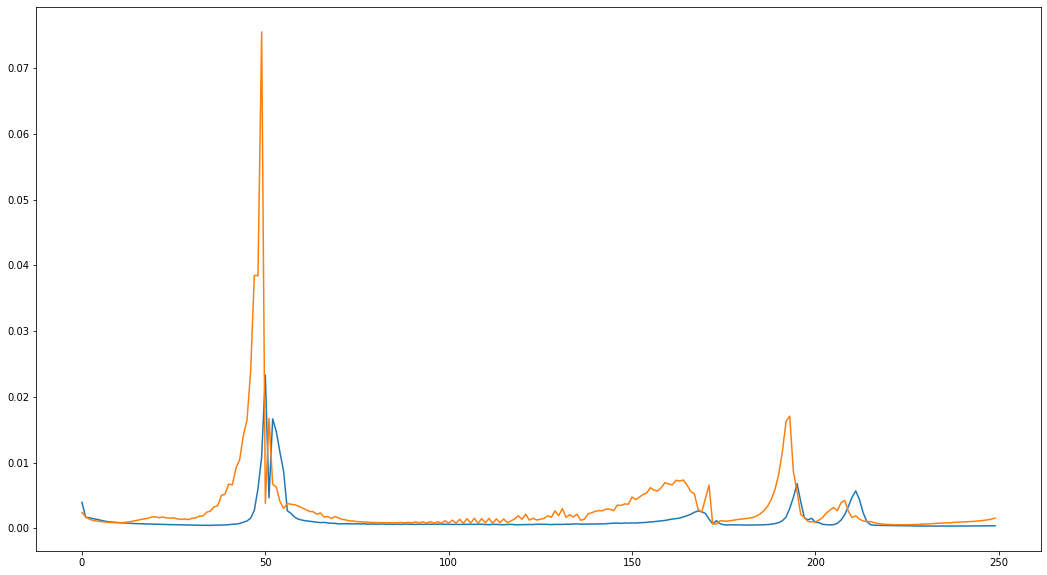

In [527]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])

7/7 [==============================] - 0s 2ms/step


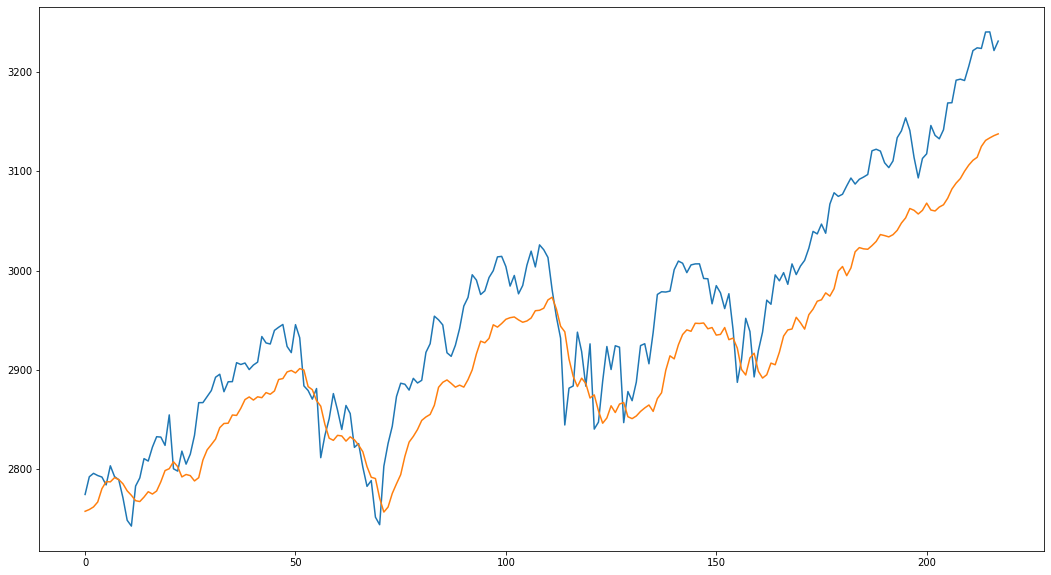

In [528]:
Xt3 = model3.predict(X_test)
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(Xt3))

In [529]:
act3 = []
pred3 = []
for i in range(X_test.shape[0]):
  # i=274
  Xt3 = model3.predict(X_test[i].reshape(1, 1, 1, 60))
  # print('predicted:{0}, actual:{1}'.format(scaler.inverse_transform(Xt),scaler.inverse_transform(y_test[i].reshape(-1,1))))
  pred3.append(scaler.inverse_transform(Xt3))
  act3.append(scaler.inverse_transform(y_test[i].reshape(-1,1)))

1/1 [==============================] - 0s 20ms/step


In [530]:
result_df3 = pd.DataFrame({'pred':list(np.reshape(pred3, (-1))),'act':list(np.reshape(act3, (-1)))})
result_df3.head(20)

,pred,act
0,2757.947754,2774.88
1,2759.732178,2792.67
2,2762.345459,2796.11
3,2767.306641,2793.90
4,2780.713867,2792.38
5,2787.772949,2784.49
6,2787.550293,2803.69
7,2791.807129,2792.81
8,2789.849609,2789.65
9,2785.577637,2771.45


In [531]:
test3 = result_df3['act']
forecast3 = result_df3['pred']

In [532]:

print('LSTM-CNN model MSE :', mean_squared_error(test3, forecast3))
print('LSTM-CNN model MAE :', mean_absolute_error(test3, forecast3))
print('LSTM-CNN model MAPE :', mean_absolute_percentage_error(test3, forecast3))

LSTM-CNN model MSE : 3442.28268161825
LSTM-CNN model MAE : 51.72327009568521
LSTM-CNN model MAPE : 0.017276769148326147
